This part covers extracting historical event timelines from Wikipedia by direct scraping, cleaning, and using a pre-trained zero-shot text classifier to infer event types. Some event types are then discarded as irrelevant for our scope.

In [222]:
import requests
from bs4 import BeautifulSoup, Tag
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Extraction Part

In [192]:
def extract_timeline(url, stop_year):
    # Fetch the HTML content
    response = requests.get(url)
    response.raise_for_status()

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    events = []

    # Find all years by selecting h3 headers for each year
    for year_heading in soup.find_all('h3'):
        year = year_heading.get_text(strip=True)

        # Find the list of events following each year header
        event_list = year_heading.find_next('ul')
        
        if event_list:
            for event in event_list.find_all('li'):
                # Extract the date (if available) and event description
                date_tag = event.find('a')
                date_text = date_tag.get_text(strip=True) if date_tag else None
                
                # Get the full text of the event including links and spaces
                event_text = ' '.join([text.get_text(strip=True) if isinstance(text, Tag) else str(text) for text in event.contents]).split(": ", 1)
                
                # Separate date and description
                if len(event_text) > 1:
                    date_text = event_text[0] if date_text else None
                    event_description = event_text[1]
                else:
                    event_description = event_text[0]

                # Append the event as a dictionary
                events.append({
                    'year': year,
                    'date': date_text,
                    'description': event_description
                })

        # Stop after reaching the final year
        if year == stop_year:
            break

    return events


In [193]:
results_20th = extract_timeline('https://en.wikipedia.org/wiki/Timeline_of_the_20th_century', '2000')
df_20th = pd.DataFrame(results_20th)
df_20th.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         1145 non-null   object
 1   date         1139 non-null   object
 2   description  1145 non-null   object
dtypes: object(3)
memory usage: 27.0+ KB


In [194]:
df_20th.head()

,year,date,description
0,1901,January 1,The Australian colonies federate . [1]
1,1901,January 22,Edward VII became King of England and India after Queen Victoria 's death.
2,1901,March 2,The Platt Amendment provides for Cuban independence in exchange for the withdrawal of American troops.
3,1901,June,Emily Hobhouse reports on the poor conditions in 45 British internment camps for Boer women and children in South Africa .
4,1901,September 6,The assassination of William McKinley ushered in office Vice President Theodore Roosevelt after McKinley's death on September 14.


In [195]:
results_21st = extract_timeline('https://en.wikipedia.org/wiki/Timeline_of_the_21st_century', '2023')
df_21st = pd.DataFrame(results_21st)
df_21st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         561 non-null    object
 1   date         557 non-null    object
 2   description  561 non-null    object
dtypes: object(3)
memory usage: 13.3+ KB


In [196]:
df_21st.head()

,year,date,description
0,2001,January 15,Wikipedia was launched.
1,2001,January 20,January 20 :\n PresidentJoseph Estradaof thePhilippinesis ousted in theSecond EDSA Revolution.George W. Bushis inaugurated asPresident of the United States.
2,2001,Joseph Estrada,President Joseph Estrada of the Philippines is ousted in the Second EDSA Revolution .
3,2001,George W. Bush,George W. Bush is inaugurated as President of the United States .
4,2001,January 26,"An earthquake strikes Gujarat , India , on Republic Day , resulting in more than 20,000 deaths."


### 2. Cleaning Part

#### 2.0 Merge both Timelines

In [197]:
# Drop empty rows
df_20th = df_20th.dropna()
df_21st = df_21st.dropna()

In [198]:
df_20th.reset_index(inplace=True)
df_21st.reset_index(inplace=True)
df = pd.concat([df_20th, df_21st], ignore_index=True)
len(df)

1696

In [199]:
df.index

RangeIndex(start=0, stop=1696, step=1)

#### 2.1 Fix date formatting

In [200]:
# Drop date rows which do not contain numbers
df = df[df['date'].str.contains(r'\d')]

df.reset_index(drop=True, inplace=True)

# Remove leading and trailing spaces from the date column
df['date'] = df['date'].str.strip()

In [201]:
len(df)

1264

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264 entries, 0 to 1263
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        1264 non-null   int64 
 1   year         1264 non-null   object
 2   date         1264 non-null   object
 3   description  1264 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.6+ KB


In [203]:
df['year'].value_counts()

year
2021    48
2020    40
2022    39
2023    34
2000    30
        ..
1907     3
1941     3
1904     3
1987     1
1984     1
Name: count, Length: 122, dtype: int64

In [204]:
# Only keep the start date when interval is given (delimited by "-")
df['date'] = df['date'].astype(str).str.split(' – ').str[0].str.strip()
df.head()

,index,year,date,description
0,0,1901,January 1,The Australian colonies federate . [1]
1,1,1901,January 22,Edward VII became King of England and India after Queen Victoria 's death.
2,2,1901,March 2,The Platt Amendment provides for Cuban independence in exchange for the withdrawal of American troops.
3,4,1901,September 6,The assassination of William McKinley ushered in office Vice President Theodore Roosevelt after McKinley's death on September 14.
4,5,1901,September 7,"The Eight-Nation Alliance defeats the Boxer Rebellion , and imposes heavy financial penalties on China ."


In [205]:
# Combine the year and date columns
df['full_date'] = df['year'].astype(str) + ' ' + df['date']

# Convert the combined date to datetime format
df['date'] = pd.to_datetime(df['full_date'], errors='coerce', yearfirst=True)

# Inspect rows with missing dates
pd.set_option('display.max_colwidth', None)
df[df['date'].isnull()]

,index,year,date,description,full_date
12,13,1902,NaT,"Venezuelan crisis of 1902–1903 , in which Britain, Germany and Italy impose a naval blockade on Venezuela in order to enforce collection of outstanding financial claims.",1902 Venezuelan crisis of 1902–1903
46,63,1908,NaT,The coldest year since 1880 according to NASA .,1908 1880
108,146,1917,NaT,October Revolution in the Russian Republic .,1917 November 7 ( O.S. October 25 )
125,172,1918,NaT,The Armistice of 11 November 1918 ends World War I .,1918 Armistice of 11 November 1918
144,198,1921,NaT,Russian famine of 1921–1922 begins.,1921 Russian famine of 1921–1922
211,276,1928,NaT,Chinese famine of 1928–1930 begins.,1928 Chinese famine of 1928–1930
226,295,1930,NaT,Soviet famine of 1930–1933 and Holodomor begin.,1930 Soviet famine of 1930–1933
266,348,1936,NaT,1936–1939 Arab revolt in Palestine against the British begins to oppose Jewish immigration.,1936 1936–1939 Arab revolt in Palestine
497,668,1968,NaT,September – Zond 5 travels to the Moon with the first lifeforms to reach Earth's satellite,1968 Zond 5
498,669,1968,NaT,"December – Apollo 8 orbits the Moon with three NASA astronauts, becoming the first human spaceflight mission to enter the gravitational influence of another celestial body.",1968 Apollo 8


In [206]:
# Drop rows with missing dates
df = df[~df['date'].isnull()]

# Reset index
df.reset_index(drop=True, inplace=True)

In [207]:
# Keep only final date column
df = df[['date', 'description']]

In [209]:
# Convert description to string
df['description'] = df['description'].astype(str)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1219 non-null   datetime64[ns]
 1   description  1219 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 19.2+ KB


In [211]:
df.head()

,date,description
0,1901-01-01,The Australian colonies federate . [1]
1,1901-01-22,Edward VII became King of England and India after Queen Victoria 's death.
2,1901-03-02,The Platt Amendment provides for Cuban independence in exchange for the withdrawal of American troops.
3,1901-09-06,The assassination of William McKinley ushered in office Vice President Theodore Roosevelt after McKinley's death on September 14.
4,1901-09-07,"The Eight-Nation Alliance defeats the Boxer Rebellion , and imposes heavy financial penalties on China ."


In [212]:
# Sanity check
print(df['date'].min())
print(df['date'].max())

1901-01-01 00:00:00
2023-12-31 00:00:00


#### 2.2 Clean descriptions

In [213]:
# Remove leading and trailing spaces
df['description'] = df['description'].str.strip()

# Remove double spaces
df['description'] = df['description'].str.replace('  ', ' ')

### 3. Event type Inference Part

#### 3.0 Import the zero-shot text classifier

In [214]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [215]:
# Define possible event types
candidate_labels = ['war', 'political instability', 'political resolution', 'natural disaster', 'catastrophe', 'pandemics', 'technological breakthrough', 'science']

#### 3.1 Execute inference

In [216]:
predictions = []
for index, row in df.iterrows():
    # Run classification
    sequence_to_classify = row['description']
    result = classifier(sequence_to_classify, candidate_labels)

    # Get the predicted event type and score
    event_type = result['labels'][0]
    event_score = result['scores'][0]
    print("------Progress:", index, "/", len(df), "------")	
    print("Description", sequence_to_classify)
    print("Predicted Event type:", event_type)
    print("Score:", event_score)
    predictions.append(event_type)

------Progress: 0 / 1219 ------
Description The Australian colonies  federate . [1]
Predicted Event type: political resolution
Score: 0.8282603025436401
------Progress: 1 / 1219 ------
Description Edward VII became King of England and India after Queen Victoria 's death.
Predicted Event type: political resolution
Score: 0.6799246668815613
------Progress: 2 / 1219 ------
Description The Platt Amendment provides for Cuban independence in exchange for the withdrawal of American troops.
Predicted Event type: political resolution
Score: 0.8571281433105469
------Progress: 3 / 1219 ------
Description The assassination of William McKinley ushered in office Vice President Theodore Roosevelt after McKinley's death on September 14.
Predicted Event type: political resolution
Score: 0.7887603640556335
------Progress: 4 / 1219 ------
Description The Eight-Nation Alliance defeats the Boxer Rebellion , and imposes heavy financial penalties on China .
Predicted Event type: political resolution
Score: 0

In [217]:
df['event_type'] = pd.Series(predictions)

In [218]:
df.head(20)

,date,description,event_type
0,1901-01-01,The Australian colonies federate . [1],political resolution
1,1901-01-22,Edward VII became King of England and India after Queen Victoria 's death.,political resolution
2,1901-03-02,The Platt Amendment provides for Cuban independence in exchange for the withdrawal of American troops.,political resolution
3,1901-09-06,The assassination of William McKinley ushered in office Vice President Theodore Roosevelt after McKinley's death on September 14.,political resolution
4,1901-09-07,"The Eight-Nation Alliance defeats the Boxer Rebellion , and imposes heavy financial penalties on China .",political resolution
5,1901-12-10,First Nobel Prizes awarded.,science
6,1901-12-12,Guglielmo Marconi received the first transatlantic radio signal.,technological breakthrough
7,1902-01-13,The Unification of Saudi Arabia begins.,political resolution
8,1902-05-20,Cuba given independence by the United States.,political resolution
9,1902-05-31,Second Boer War ends in British victory.,war


#### 3.2 Inspect & clean predictions

In [219]:
df.sample(20)

,date,description,event_type
698,1990-05-22,North and South Yemen unify to form the Republic of Yemen .,political resolution
555,1976-04-01,"Steve Wozniak invents the Apple I and Steve Jobs then convinces Wozniak to sell the system, giving birth to Apple Computer .",technological breakthrough
1193,2023-03-10,Iran and Saudi Arabia restore diplomatic relations.,political resolution
1074,2020-07-09,Protests begin in Bulgaria against the government of prime minister Boyko Borisov .,political instability
321,1948-01-30,Assassination of Mahatma Gandhi .,catastrophe
1148,2021-12-16,"Typhoon Rai lashes into Visayas and Mindanao , killing 409 people.",natural disaster
886,2001-10-07,"The United States invades Afghanistan and topples the Taliban regime , resulting in a long-term war .",war
507,1970-07-12,"Thor Heyerdahl 's papyrus boat Ra II arrived in Barbados , bringing an end to its 3,200 mi (5,100 km) journey across the Atlantic Ocean.",technological breakthrough
688,1989-12-17,The first episode of The Simpsons premieres on Fox .,technological breakthrough
595,1979-10-15,Beginning of the Salvadoran Civil War .,war


In [220]:
df["event_type"].value_counts()

event_type
political resolution          420
catastrophe                   203
war                           200
technological breakthrough    195
political instability          84
science                        60
natural disaster               49
pandemics                       8
Name: count, dtype: int64

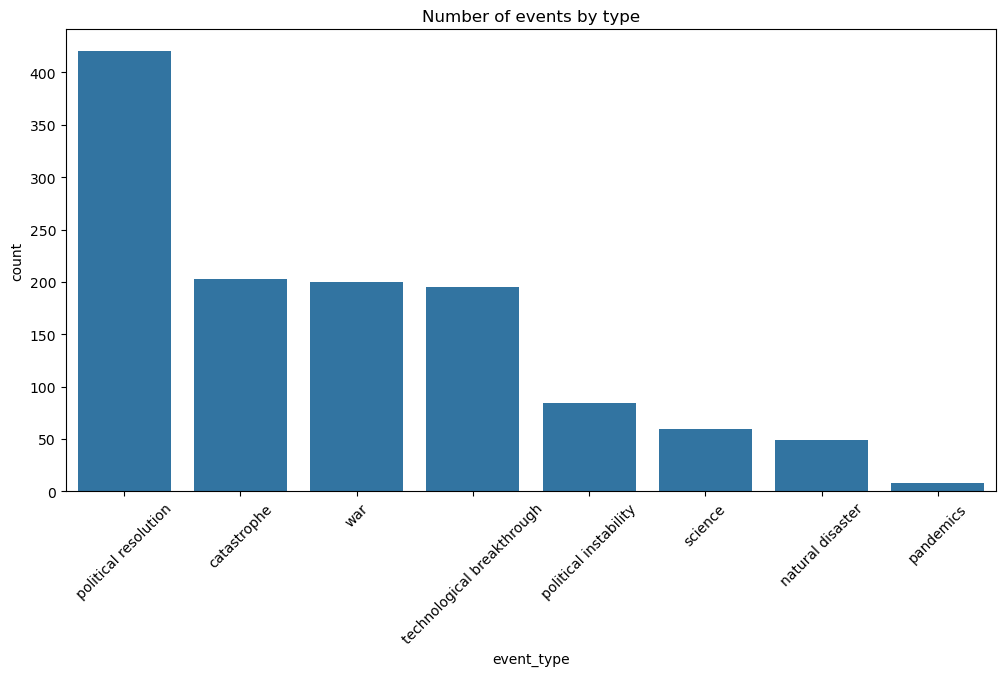

In [223]:
# Graph the number of events by type
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='event_type', order=df['event_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Number of events by type')
plt.show()

In [241]:
# Drop events predicted as having positive or neutral impact
df = df[~df['event_type'].isin(['political resolution', 'science', 'technological breakthrough'])]

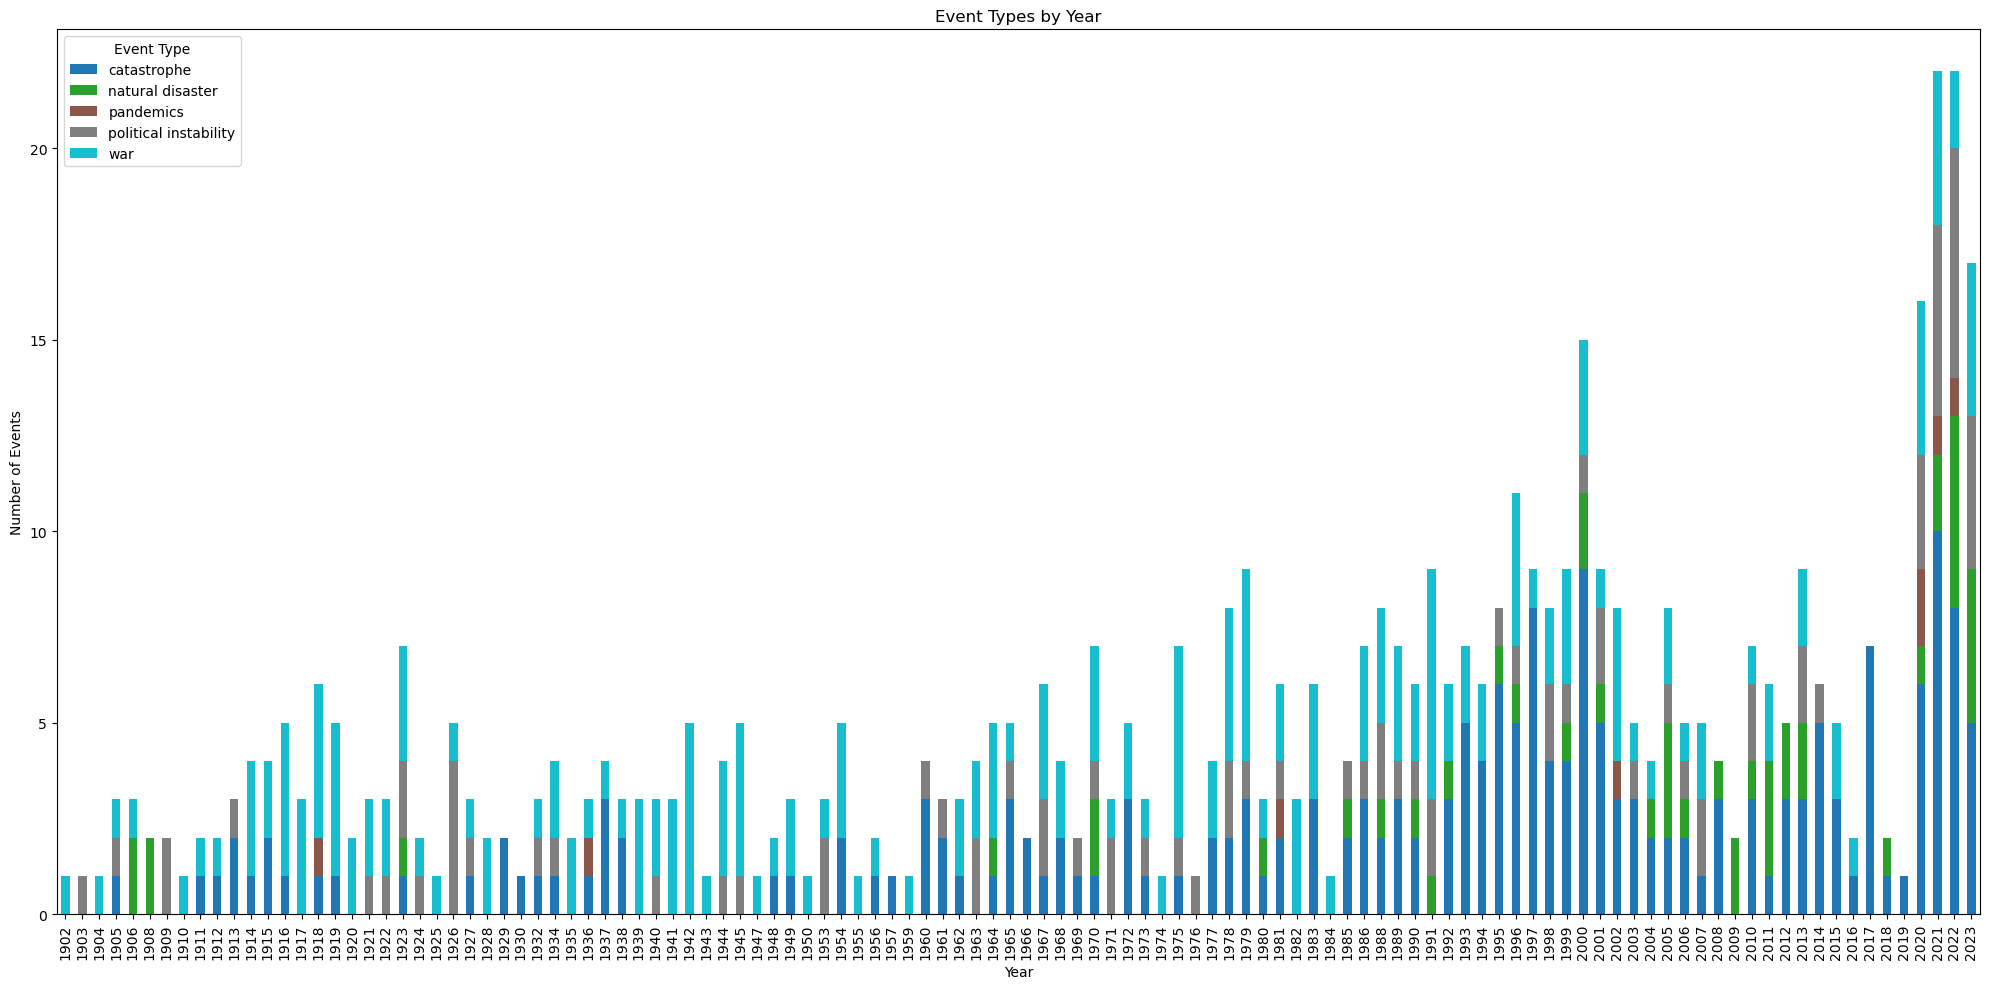

In [ ]:
# Plot the event types by year
df_year = df.copy()
df_year['year'] = df_year['date'].dt.year

# Group by year and event type, and count occurrences
df_grouped = df_year.groupby(['year', 'event_type']).size().reset_index(name='count')

# Pivot to get data in wide format for stacking
df_pivot = df_grouped.pivot(index='year', columns='event_type', values='count').fillna(0)

# Plot the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(20, 10), cmap='tab10')

plt.title("Event Types by Year")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.legend(title="Event Type")
plt.tight_layout()


#### 3.3 Export prepared dataset

In [243]:
df.to_csv('../data/events.csv', index=False)